# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8]
regularization_strengths = [5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=5000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        # compute the accuracy for training and validation
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (acc_train, acc_val)
        # check if this is better than the current best model
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 806.330833
iteration 100 / 5000: loss 661.742807
iteration 200 / 5000: loss 543.343203
iteration 300 / 5000: loss 446.474246
iteration 400 / 5000: loss 367.125895
iteration 500 / 5000: loss 302.174333
iteration 600 / 5000: loss 249.005947
iteration 700 / 5000: loss 205.490608
iteration 800 / 5000: loss 169.846075
iteration 900 / 5000: loss 140.682968
iteration 1000 / 5000: loss 116.804358
iteration 1100 / 5000: loss 97.248237
iteration 1200 / 5000: loss 81.242447
iteration 1300 / 5000: loss 68.141978
iteration 1400 / 5000: loss 57.419222
iteration 1500 / 5000: loss 48.637891
iteration 1600 / 5000: loss 41.449547
iteration 1700 / 5000: loss 35.563373
iteration 1800 / 5000: loss 30.747292
iteration 1900 / 5000: loss 26.803491
iteration 2000 / 5000: loss 23.576200
iteration 2100 / 5000: loss 20.932849
iteration 2200 / 5000: loss 18.769452
iteration 2300 / 5000: loss 16.996629
iteration 2400 / 5000: loss 15.546715
iteration 2500 / 5000: loss 14.359351
iteration 260

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


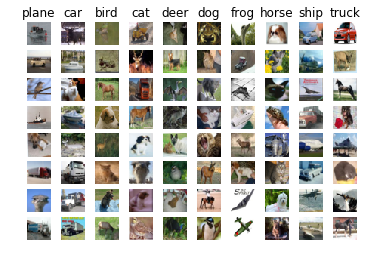

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 165)
(49000, 164)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

hidden_sizes = [500, 1000, 1500]
learning_rates = [1, 0.5]
regs = [1e-4, 5e-4]
num_iters = [5000]
num_classes = 10

best_acc = -1
best_net = None

# Train the network
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for reg in regs:
            for num_iter in num_iters:
                net = TwoLayerNet(input_dim, hidden_size, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                  num_iters=num_iter, batch_size=200,
                                  learning_rate=learning_rate, 
                                  learning_rate_decay=0.95, reg=reg,
                                  verbose=True);

                # Predict on the validation set
                acc = stats['val_acc_history'][-1]
                print('for hidden_size: %i, learning_rate: %e, regularisation strength: %f, and epochs: %i, the validation accuracy is: %f' %(hidden_size, learning_rate, reg, num_iter, acc))
                
                if acc > best_acc:
                    print('new best network!')
                    best_net = net
                    best_acc = acc
                    best_hidden_size = hidden_size
                    best_learning_rate = learning_rate
                    best_reg = reg
                    best_num_iter = num_iter

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.538801
iteration 200 / 5000: loss 1.578220
iteration 300 / 5000: loss 1.118595
iteration 400 / 5000: loss 1.239464
iteration 500 / 5000: loss 1.055301
iteration 600 / 5000: loss 1.087198
iteration 700 / 5000: loss 1.230604
iteration 800 / 5000: loss 1.242742
iteration 900 / 5000: loss 1.040127
iteration 1000 / 5000: loss 0.949938
iteration 1100 / 5000: loss 1.142113
iteration 1200 / 5000: loss 1.057061
iteration 1300 / 5000: loss 0.866355
iteration 1400 / 5000: loss 1.012818
iteration 1500 / 5000: loss 0.872872
iteration 1600 / 5000: loss 0.915232
iteration 1700 / 5000: loss 0.856556
iteration 1800 / 5000: loss 0.804151
iteration 1900 / 5000: loss 0.717204
iteration 2000 / 5000: loss 0.713174
iteration 2100 / 5000: loss 0.617630
iteration 2200 / 5000: loss 0.868090
iteration 2300 / 5000: loss 0.695256
iteration 2400 / 5000: loss 0.674596
iteration 2500 / 5000: loss 0.548947
iteration 2600 / 5000: loss 0.659133
iteration 270

iteration 700 / 5000: loss 1.024200
iteration 800 / 5000: loss 1.052043
iteration 900 / 5000: loss 1.047380
iteration 1000 / 5000: loss 1.090706
iteration 1100 / 5000: loss 0.842239
iteration 1200 / 5000: loss 0.858911
iteration 1300 / 5000: loss 0.988721
iteration 1400 / 5000: loss 0.821659
iteration 1500 / 5000: loss 0.844610
iteration 1600 / 5000: loss 0.764995
iteration 1700 / 5000: loss 0.785226
iteration 1800 / 5000: loss 0.764209
iteration 1900 / 5000: loss 0.853246
iteration 2000 / 5000: loss 0.890469
iteration 2100 / 5000: loss 0.625955
iteration 2200 / 5000: loss 0.761634
iteration 2300 / 5000: loss 0.682506
iteration 2400 / 5000: loss 0.502795
iteration 2500 / 5000: loss 0.548816
iteration 2600 / 5000: loss 0.556522
iteration 2700 / 5000: loss 0.553437
iteration 2800 / 5000: loss 0.460393
iteration 2900 / 5000: loss 0.489408
iteration 3000 / 5000: loss 0.591153
iteration 3100 / 5000: loss 0.506045
iteration 3200 / 5000: loss 0.418866
iteration 3300 / 5000: loss 0.431214
iter

iteration 1400 / 5000: loss 0.860286
iteration 1500 / 5000: loss 0.912837
iteration 1600 / 5000: loss 0.919080
iteration 1700 / 5000: loss 0.780660
iteration 1800 / 5000: loss 0.722641
iteration 1900 / 5000: loss 0.907237
iteration 2000 / 5000: loss 0.758454
iteration 2100 / 5000: loss 0.710586
iteration 2200 / 5000: loss 0.589169
iteration 2300 / 5000: loss 0.639832
iteration 2400 / 5000: loss 0.658915
iteration 2500 / 5000: loss 0.576526
iteration 2600 / 5000: loss 0.714348
iteration 2700 / 5000: loss 0.504372
iteration 2800 / 5000: loss 0.442767
iteration 2900 / 5000: loss 0.458122
iteration 3000 / 5000: loss 0.502528
iteration 3100 / 5000: loss 0.419843
iteration 3200 / 5000: loss 0.431110
iteration 3300 / 5000: loss 0.409295
iteration 3400 / 5000: loss 0.393416
iteration 3500 / 5000: loss 0.352220
iteration 3600 / 5000: loss 0.367892
iteration 3700 / 5000: loss 0.388077
iteration 3800 / 5000: loss 0.326816
iteration 3900 / 5000: loss 0.325283
iteration 4000 / 5000: loss 0.291751
i

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.592
